In [1]:
import sys
sys.path.append('../')
sys.path.append('../prompt2prompt/')
from prompt2prompt.attension_control import *
import torch
from diffusers import StableDiffusionPipeline
from prompt2prompt.ptp_utils import latent2image

In [2]:
LOW_RESOURCE = False 
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
tokenizer = ldm_stable.tokenizer

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [3]:
def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))
    

def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))

In [4]:
def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = ptp_utils.text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE)
    ptp_utils.view_images(images)
    return images, x_t

/home/yutong/Images_Pair_Generation/test/../prompt2prompt/ptp_utils.py:105: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, model.unet.in_channels, height // 8, width // 8),
/home/yutong/Images_Pair_Generation/test/../prompt2prompt/ptp_utils.py:108: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size, model.unet.in_channels, height // 8, width // 8).to(model.device)


  0%|          | 0/51 [00:00<?, ?it/s]

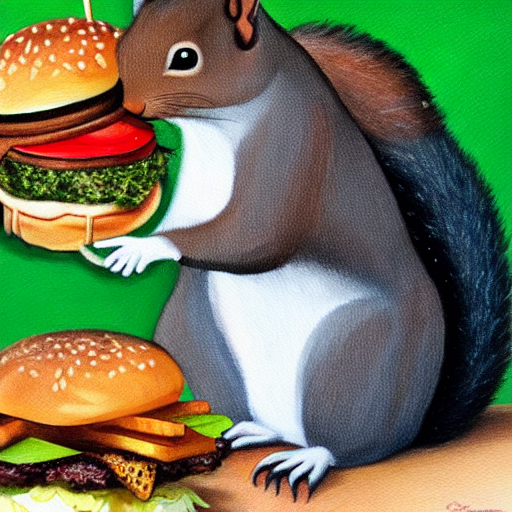

In [5]:
g_cpu = torch.Generator().manual_seed(8888)
prompts = ["A painting of a squirrel eating a burger"]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
# show_cross_attention(controller, res=16, from_where=("up", "down"))

In [10]:
Image.fromarray(image[0]).save("./images/A painting of a squirrel eating a burger.png")

In [11]:
# with torch.no_grad():
#     encoder = ldm_stable.vae.encoder
#     input_image = torch.from_numpy(image).to(device).permute(0, 3, 1, 2).float() / 255.
#     input_image = input_image * 2 - 1
#     latents = 0.18215 * encoder(input_image)[:, :4, ...]
#     reconstructed = latent2image(ldm_stable.vae, latents)
#     ptp_utils.view_images(image)

/home/yutong/Images_Pair_Generation/test/../prompt2prompt/ptp_utils.py:108: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size, model.unet.in_channels, height // 8, width // 8).to(model.device)


  0%|          | 0/51 [00:00<?, ?it/s]

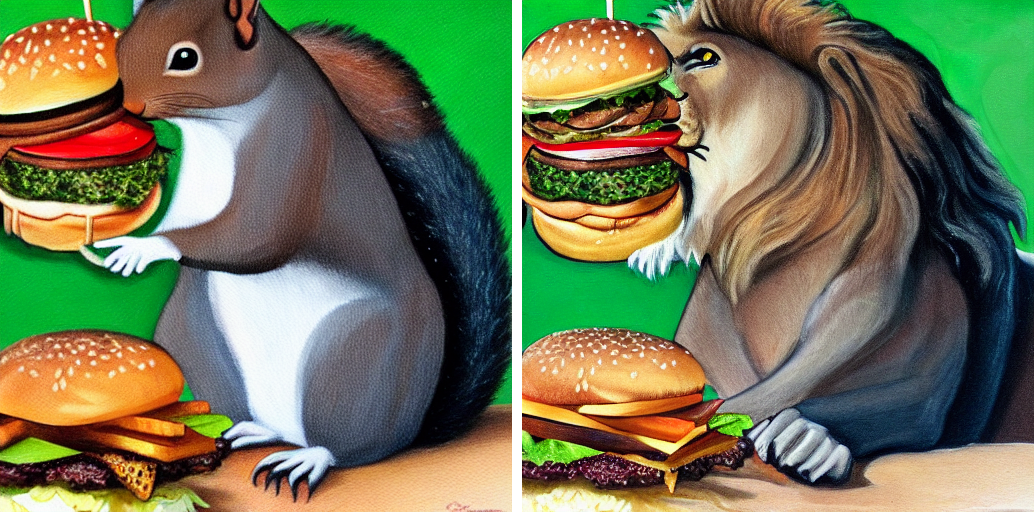

In [22]:
prompts = ["A painting of a squirrel eating a burger",
           "A painting of a lion eating a burger"]

controller = AttentionReplace(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps=.8, self_replace_steps=0.4)
_ = run_and_display(prompts, controller, latent=x_t, run_baseline=False)

  0%|          | 0/51 [00:00<?, ?it/s]

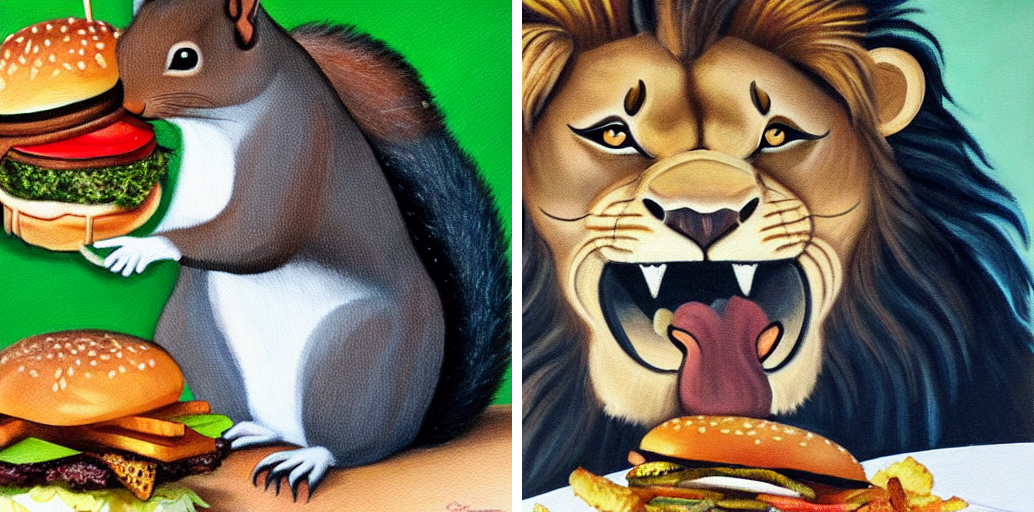

In [30]:
controller = EmptyControl()
temp_images, temp_x_t = ptp_utils.text2image_ldm_stable(ldm_stable, prompts, controller, latent=x_t, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=g_cpu, low_resource=LOW_RESOURCE)
ptp_utils.view_images(temp_images)

/home/yutong/Images_Pair_Generation/test/../prompt2prompt/ptp_utils.py:108: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size, model.unet.in_channels, height // 8, width // 8).to(model.device)


  0%|          | 0/51 [00:00<?, ?it/s]

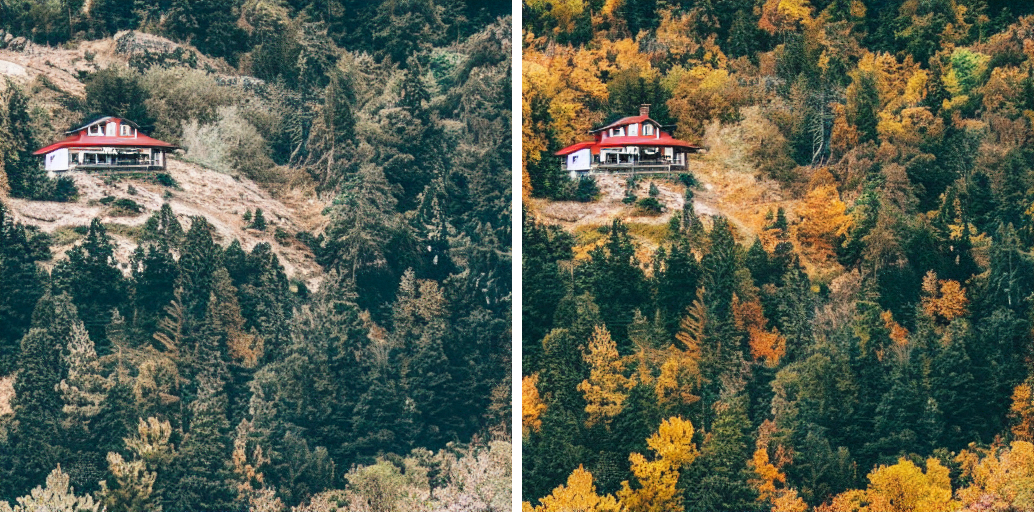

In [32]:
prompts = ["a photo of a house on a mountain",
           "a photo of a house on a mountain at fall"]


controller = AttentionRefine(prompts, tokenizer, NUM_DIFFUSION_STEPS, cross_replace_steps=.8,
                             self_replace_steps=.4)
_ = run_and_display(prompts, controller, latent=x_t)